------------------------------
PERFORMANCE METRICS
------------------------------
MSE (OLS):   0.2556
MSE (Ridge): 0.2568 (Expected to be slightly higher due to bias-variance tradeoff)
------------------------------


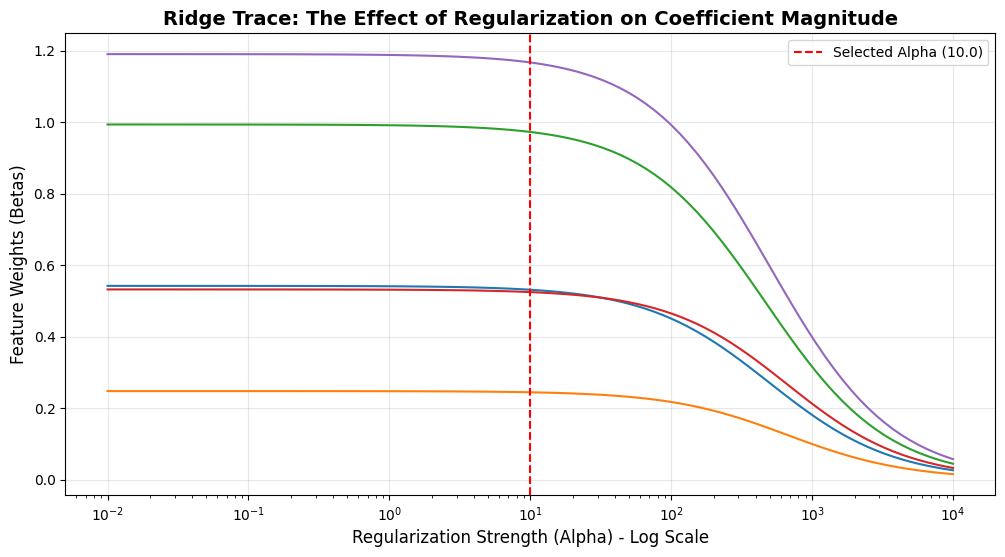

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CORE ESTIMATORS (The "Engine") ---

def add_bias(X):
    """
    Appends a column of 1s to X to act as the Intercept (Bias).
    """
    return np.c_[np.ones((X.shape[0], 1)), X]

def mse(y, yhat):
    """
    Calculates Mean Squared Error.
    """
    return np.mean((y - yhat)**2)

def fit_ols_closed_form(X, y):
    """
    Derives Ordinary Least Squares (OLS) coefficients via Normal Equations.
    Formula: beta = (X'X)^-1 X'y
    """
    XtX = X.T @ X
    Xty = X.T @ y
    # np.linalg.solve is numerically more stable than inv()
    beta = np.linalg.solve(XtX, Xty)
    return beta

def fit_ridge_closed_form(X, y, alpha=1.0):
    """
    Derives Ridge Regression (L2) coefficients.
    Formula: beta = (X'X + alpha*I)^-1 X'y

    CRITICAL QUANT NUANCE:
    We do NOT penalize the intercept (bias) term.
    Shrinking the intercept forces the model to assume a zero-mean target,
    which introduces significant bias in financial time series.
    """
    n_features = X.shape[1]

    # Create Identity matrix for penalty
    I = np.eye(n_features)

    # --- QUANT FIX: Turn off penalty for the Intercept (Index 0) ---
    I[0, 0] = 0.0

    XtX = X.T @ X
    Xty = X.T @ y

    # Solve with Regularization
    beta = np.linalg.solve(XtX + alpha * I, Xty)
    return beta

# --- 2. SYNTHETIC DATA GENERATION (The "Simulation") ---
rng = np.random.default_rng(42)
n_samples = 500
n_features = 5

# Generate random features (X)
X = rng.normal(size=(n_samples, n_features))

# Define "True" Betas (The hidden signal we want to recover)
true_beta = rng.normal(size=(n_features,))

# Generate Target (y) with some noise
# y = X * beta + noise
y = X @ true_beta + rng.normal(scale=0.5, size=n_samples)

# Add Intercept to X
Xb = add_bias(X)

# --- 3. MODEL EXECUTION ---

# Fit OLS
beta_ols = fit_ols_closed_form(Xb, y)

# Fit Ridge (with Alpha=10.0)
beta_ridge = fit_ridge_closed_form(Xb, y, alpha=10.0)

# Generate Predictions
yhat_ols = Xb @ beta_ols
yhat_ridge = Xb @ beta_ridge

# --- 4. PERFORMANCE REPORTING ---

print(f"{'-'*30}")
print(f"PERFORMANCE METRICS")
print(f"{'-'*30}")
print(f"MSE (OLS):   {mse(y, yhat_ols):.4f}")
print(f"MSE (Ridge): {mse(y, yhat_ridge):.4f} (Expected to be slightly higher due to bias-variance tradeoff)")
print(f"{'-'*30}")

# --- 5. VISUALIZATION: THE RIDGE TRACE ---
# This proves you understand how regularization suppresses variance.

alphas = np.logspace(-2, 4, 100)
coefs = []

for a in alphas:
    beta = fit_ridge_closed_form(Xb, y, alpha=a)
    # Exclude the intercept (index 0) from the plot to focus on feature weights
    coefs.append(beta[1:])

plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Regularization Strength (Alpha) - Log Scale', fontsize=12)
plt.ylabel('Feature Weights (Betas)', fontsize=12)
plt.title('Ridge Trace: The Effect of Regularization on Coefficient Magnitude', fontsize=14, fontweight='bold')
plt.axis('tight')
plt.grid(True, alpha=0.3)

# Add a marker for our specific model
plt.axvline(x=10.0, color='red', linestyle='--', label='Selected Alpha (10.0)')
plt.legend()
plt.show()